# 批量规范化

从零实现，归一化公式$\hat{X}=\frac{X-\mu}{\sqrt{\sigma ^2+\epsilon } }   $

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

'''
X: 输入数据，可以是2D（全连接层）或4D（卷积层）张量
gamma: 缩放参数（可学习）
beta: 平移参数（可学习）
moving_mean: 全局移动的均值（预测时使用）
moving_var: 全局移动的方差（预测时使用）
eps: 微小常数，防止除零错误
momentum: 动量因子，控制历史统计量更新速度
'''
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 1. 预测模式 (梯度关闭)
    if not torch.is_grad_enabled():
        '''
        (X - moving_mean)：中心化
        将输入数据 X 减去全局移动平均均值 μ，使数据分布中心为零点
        moving_var + eps：数值保护
        σ2是全局移动平均方差，添加极小常数 ϵ（如1e-5）防止分母为零
        torch.sqrt(...)：标准化
        计算标准差，将数据缩放至单位方差，最终输出  
        X^是均值为0、方差为1的标准分布
        '''
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    # 2. 训练模式 (梯度开启)
    else:
        # 2D输入 → 全连接层 (Dense/Linear)，4D输入 → 2D卷积层 (Conv2D)
        assert len(X.shape) in (2, 4) # 只支持2D或4D输入
        # 2D输入处理（全连接层）：
        if len(X.shape) == 2:
            mean = X.mean(dim=0) # 对batch维度求均值，形状：[特征数]
            var = ((X - mean) ** 2).mean(dim=0) # 计算方差，dim=0：对batch维度计算，每个特征独立统计
        # 4D输入处理（卷积层）：
        else:
            mean = X.mean(dim=(0, 2, 3), keepdim=True) # 在N,H,W维度求均值
            # dim=(0,2,3)：在batch、height、width维度上计算
            # keepdim=True：保持维度以便广播，形状：[1, 通道数, 1, 1]
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 归一化：
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均统计量：
        # momentum通常接近1（如0.9），新值 = 旧值×momentum + 新批次值×(1-momentum)
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    # 3. 缩放和平移
    # 这是BN的关键步骤，让网络可以学习恢复归一化可能丢失的表达能力
    # 如果 gamma=1, beta=0，则等价于标准白化
    Y = gamma * X_hat + beta
    # 4. 返回值
    # Y: 归一化后的输出
    # moving_mean.data / moving_var.data: 更新后的统计量（用.data避免被autograd追踪）
    return Y, moving_mean.data, moving_var.data

创建一个正确的`BatchNorm`层

In [2]:
class BatchNorm(nn.Module):
    # num_features: 特征数量（全连接层）或通道数量（卷积层）
    # num_dims: 指定输入维度，只能是 2（全连接）或 4（卷积）
    def __init__(self, num_features, num_dims):
        super().__init__()
        # 2D输入[batch,features]→参数形状(1,num_features)
        if num_dims == 2:
            shape = (1, num_features)
        # 4D输入[batch,channels,h,w]→参数形状 (1,num_features,1,1)
        # 添加两个1是为了广播机制，让参数能作用于每个空间位置
        else:
            shape = (1, num_features, 1, 1)
        # 可学习参数，shape维度适配
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 全局统计量
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 设备自动同步
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

应用`BatchNorm`
于LeNet模型

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

在Fashion-MNIST数据集上训练网络

loss 0.259, train acc 0.904, test acc 0.865
24361.1 examples/sec on cuda:0


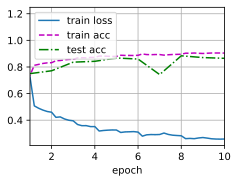

In [4]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

拉伸参数`gamma`和偏移参数`beta`

In [5]:
'''
1. net[1]
含义：访问网络 net 的第2个层（Python从0开始索引）
假设：net 是一个 nn.Sequential 容器，且第2层是自定义的BatchNorm层
2. .gamma 和 .beta
作用：获取BatchNorm层的两个可训练参数
gamma：缩放参数（初始值全1）
beta：平移参数（初始值全0）
3. .reshape((-1,))
功能：将任意形状的张量展平为一维向量
-1：自动计算该维度大小（总元素数不变）
示例：(1, 64, 1, 1) → (64,)（64个参数）
'''
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([2.7743, 2.9465, 1.8327, 1.5395, 2.8956, 4.7368], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([-2.7927,  1.8589, -0.6774, -1.5851, -3.2126,  2.5526], device='cuda:0',
        grad_fn=<ViewBackward0>))

简明实现

In [6]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

使用相同超参数来训练模型

loss 0.265, train acc 0.902, test acc 0.811
28506.6 examples/sec on cuda:0


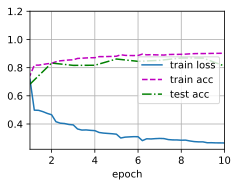

In [7]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())